In [14]:
%load_ext autoreload
%autoreload 2
import time
import objax
import bayesnewton
import jax.numpy as jnp
import matplotlib.pyplot as plt
from model import ExactMarkovGP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Make some training data
N_temporal_train = 100
N_x, N_y = 4, 6
N_spatial = N_x * N_y
N_dim = 2
t = jnp.linspace(0., 2., N_temporal_train)
x = jnp.linspace(0., 1., N_x)
y = jnp.linspace(0., 1., N_y)
x, y = jnp.meshgrid(x, y)
r = jnp.stack([x.ravel(), x.ravel()], axis=1)
R = jnp.tile(r, (N_temporal_train, 1, 1))
X = jnp.concatenate([jnp.tile(t[:, None], N_spatial).reshape(-1, 1), R.reshape(-1, N_dim)], axis=1) # Need to compute Y
Y = (5 * X[:, 0] + jnp.sin(2*jnp.pi*X[:, 0]) + 3 * X[:, 1]) + 10 * X[:, 2]
Y = Y.reshape(N_temporal_train, N_spatial)
t.shape, R.shape, Y.shape

((100,), (100, 24, 2), (100, 24))

In [9]:
# Define spatiotemporal kernel and measurement noise, and initialise hyperparameters
lengthscale_spatial = 0.1
lengthscale_temporal = 1.4
variance_spatial = 2.0
variance_temporal = 120
variance_noise = 0.001

lik = bayesnewton.likelihoods.Gaussian(variance=variance_noise)
kern_time = bayesnewton.kernels.Matern52(variance=variance_temporal, lengthscale=lengthscale_temporal)
kern_space = bayesnewton.kernels.Matern52(variance=variance_spatial, lengthscale=lengthscale_spatial)
kernel = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time, spatial_kernel=kern_space, z=R[0], sparse=False, opt_z=False)
gp = ExactMarkovGP(kernel=kernel, likelihood=lik, X=t, Y=Y, R=R)

In [10]:
t_test = jnp.linspace(0., 3., 100)[:, None]
test_mean, test_std = gp.predict(t_test)

Text(0.5, 1.0, 'Marginal likelihood: 4554.268278800158')

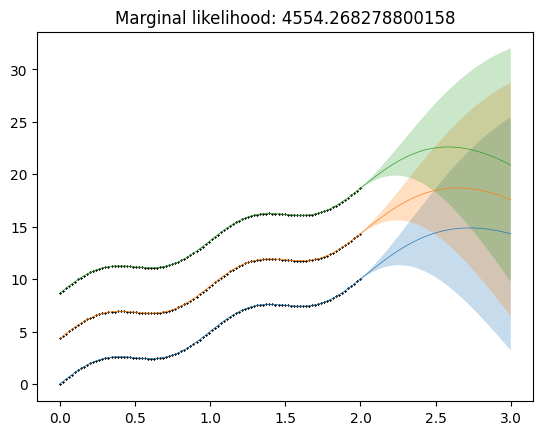

In [11]:
plt.plot(t, Y[:, :3], color='black', marker='x', linestyle='none', ms=1)
plt.plot(t_test, test_mean[:, :3], lw=.5)
plt.fill_between(t_test.squeeze(), test_mean[:, 0] - 2 * test_std[:, 0], test_mean[:, 0] + 2 * test_std[:, 0], alpha=0.25)
plt.fill_between(t_test.squeeze(), test_mean[:, 1] - 2 * test_std[:, 1], test_mean[:, 1] + 2 * test_std[:, 1], alpha=0.25)
plt.fill_between(t_test.squeeze(), test_mean[:, 2] - 2 * test_std[:, 2], test_mean[:, 2] + 2 * test_std[:, 2], alpha=0.25)
plt.title(f"Marginal likelihood: {-gp.filter_energy()}")

In [17]:
# Optimise the hyperparameters
lr_adam = 0.025
epochs = 10

opt_hypers = objax.optimizer.Adam(gp.vars())
energy = objax.GradValues(gp.filter_energy, gp.vars())

def train_op():
    grads, loss_ = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, grads)
    return loss_[0]

train_op = objax.Jit(train_op, gp.vars())

t0 = time.time()
for i in range(1, epochs+1):
    loss = train_op()
    print('epoch %2d: loss: %1.4f' % (i, loss))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

epoch  1: loss: -4974.9424
epoch  2: loss: -4975.9632
epoch  3: loss: -4977.0001
epoch  4: loss: -4977.9749
epoch  5: loss: -4978.9614
epoch  6: loss: -4979.8920
epoch  7: loss: -4980.8308
epoch  8: loss: -4981.7188
epoch  9: loss: -4982.6124
epoch 10: loss: -4983.4595
optimisation time: 1.22 secs


In [18]:
print(lengthscale_spatial, lengthscale_temporal, variance_spatial, variance_temporal)
gp.kernel.spatial_kernel.lengthscale, gp.kernel.temporal_kernel.lengthscale, gp.kernel.spatial_kernel.variance, gp.kernel.temporal_kernel.variance

0.1 1.4 2.0 120


(Array(0.1, dtype=float64),
 Array(1.49558744, dtype=float64),
 Array(2., dtype=float64),
 Array(122.57474069, dtype=float64))

Text(0.5, 1.0, 'Marginal likelihood: 4984.310387865953')

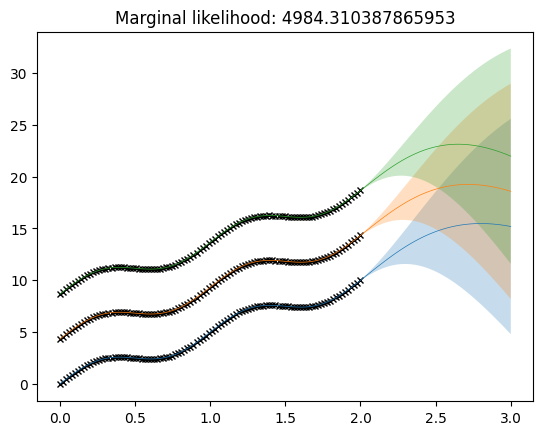

In [19]:
# Extrapolate in time for three spatial locations
t_test = jnp.linspace(0., 3., 100)[:, None]
test_mean, test_std = gp.predict(t_test)
plt.plot(t, Y[:, :3], color='black', marker='x', linestyle='none', ms=5)
plt.plot(t_test, test_mean[:, :3], lw=.5)
plt.fill_between(t_test.squeeze(), test_mean[:, 0] - 2 * test_std[:, 0], test_mean[:, 0] + 2 * test_std[:, 0], alpha=0.25)
plt.fill_between(t_test.squeeze(), test_mean[:, 1] - 2 * test_std[:, 1], test_mean[:, 1] + 2 * test_std[:, 1], alpha=0.25)
plt.fill_between(t_test.squeeze(), test_mean[:, 2] - 2 * test_std[:, 2], test_mean[:, 2] + 2 * test_std[:, 2], alpha=0.25)
plt.title(f"Marginal likelihood: {-gp.filter_energy()}")